<h1>Final Project Report</h1>

**What factors are strongly related to heart disease, and can we classify the presence of heart disease in new patients based on those factors?**

<h1>Introduction</h1>

Heart disease, also known as cardiovascular disease, refers to a range of conditions that affect the heart and blood vessels. Among these conditions is Coronary Artery Disease (CAD), which is characterized by the narrowing of blood vessels leading to the heart. According to the World Health Organization (WHO), heart disease is the leading cause of death worldwide, with CAD accounting for the majority of these deaths (World Health Organization, 2021). This research project analyzes data provided by the Hungarian Institute of Cardiology (Janosi et al., 1988) to answer the question, “What factors that are strongly related to heart disease, and can we determine the presence of heart disease in new patients based on those factors?”. The original database, the processed.hungarian.data, contains 76 categorical and comma-separated attributes, but the publishers considered only a subset of 14 attributes to be of importance. The data set has x columns and y rows. The explanatory variable we will be using to classify the presence or absence of heart disease is the "num" attribute, which has two binary labels: "0" for the absence of heart disease and "1" for the presence of heart disease.

<h1>Methods and Results</h1>

<h2>Preliminary Exploratory Data Analysis</h2>

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

<h4>1. Reading dataset from web:</h4>

In [3]:
data_raw <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", delim=",", col_names = FALSE)
colnames(data_raw) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
tail(data_raw)

# Changing the name of our explanatory variable, num, to "diagnosis" for simpler interpretation 
data <- data_raw|>
        mutate(diagnosis = num)|>
        select(-num)
tail(data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
52,1,4,140,266,0,0,134,1,2.0,2,?,?,1
52,1,4,160,331,0,0,94,1,2.5,?,?,?,1
54,0,3,130,294,0,1,100,1,0.0,2,?,?,1
56,1,4,155,342,1,0,150,1,3.0,2,?,?,1
58,0,2,180,393,0,0,110,1,1.0,2,?,7,1
65,1,4,130,275,0,1,115,1,1.0,2,?,?,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
52,1,4,140,266,0,0,134,1,2.0,2,?,?,1
52,1,4,160,331,0,0,94,1,2.5,?,?,?,1
54,0,3,130,294,0,1,100,1,0.0,2,?,?,1
56,1,4,155,342,1,0,150,1,3.0,2,?,?,1
58,0,2,180,393,0,0,110,1,1.0,2,?,7,1
65,1,4,130,275,0,1,115,1,1.0,2,?,?,1


<h4>2. Analyzing and choosing the predictor variables:</h4>

- We excluded the "slope", "ca", and "thal" variables because their columns do not contain data
- We excluded the columns "sex", "fbs", "restecg", and "exang" variables because they are categorical, and thus, cannot be used as predictors

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removing 1 row that contained a missing value”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 23 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removing 1 row that contained a missing value”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 24 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removing 1 r

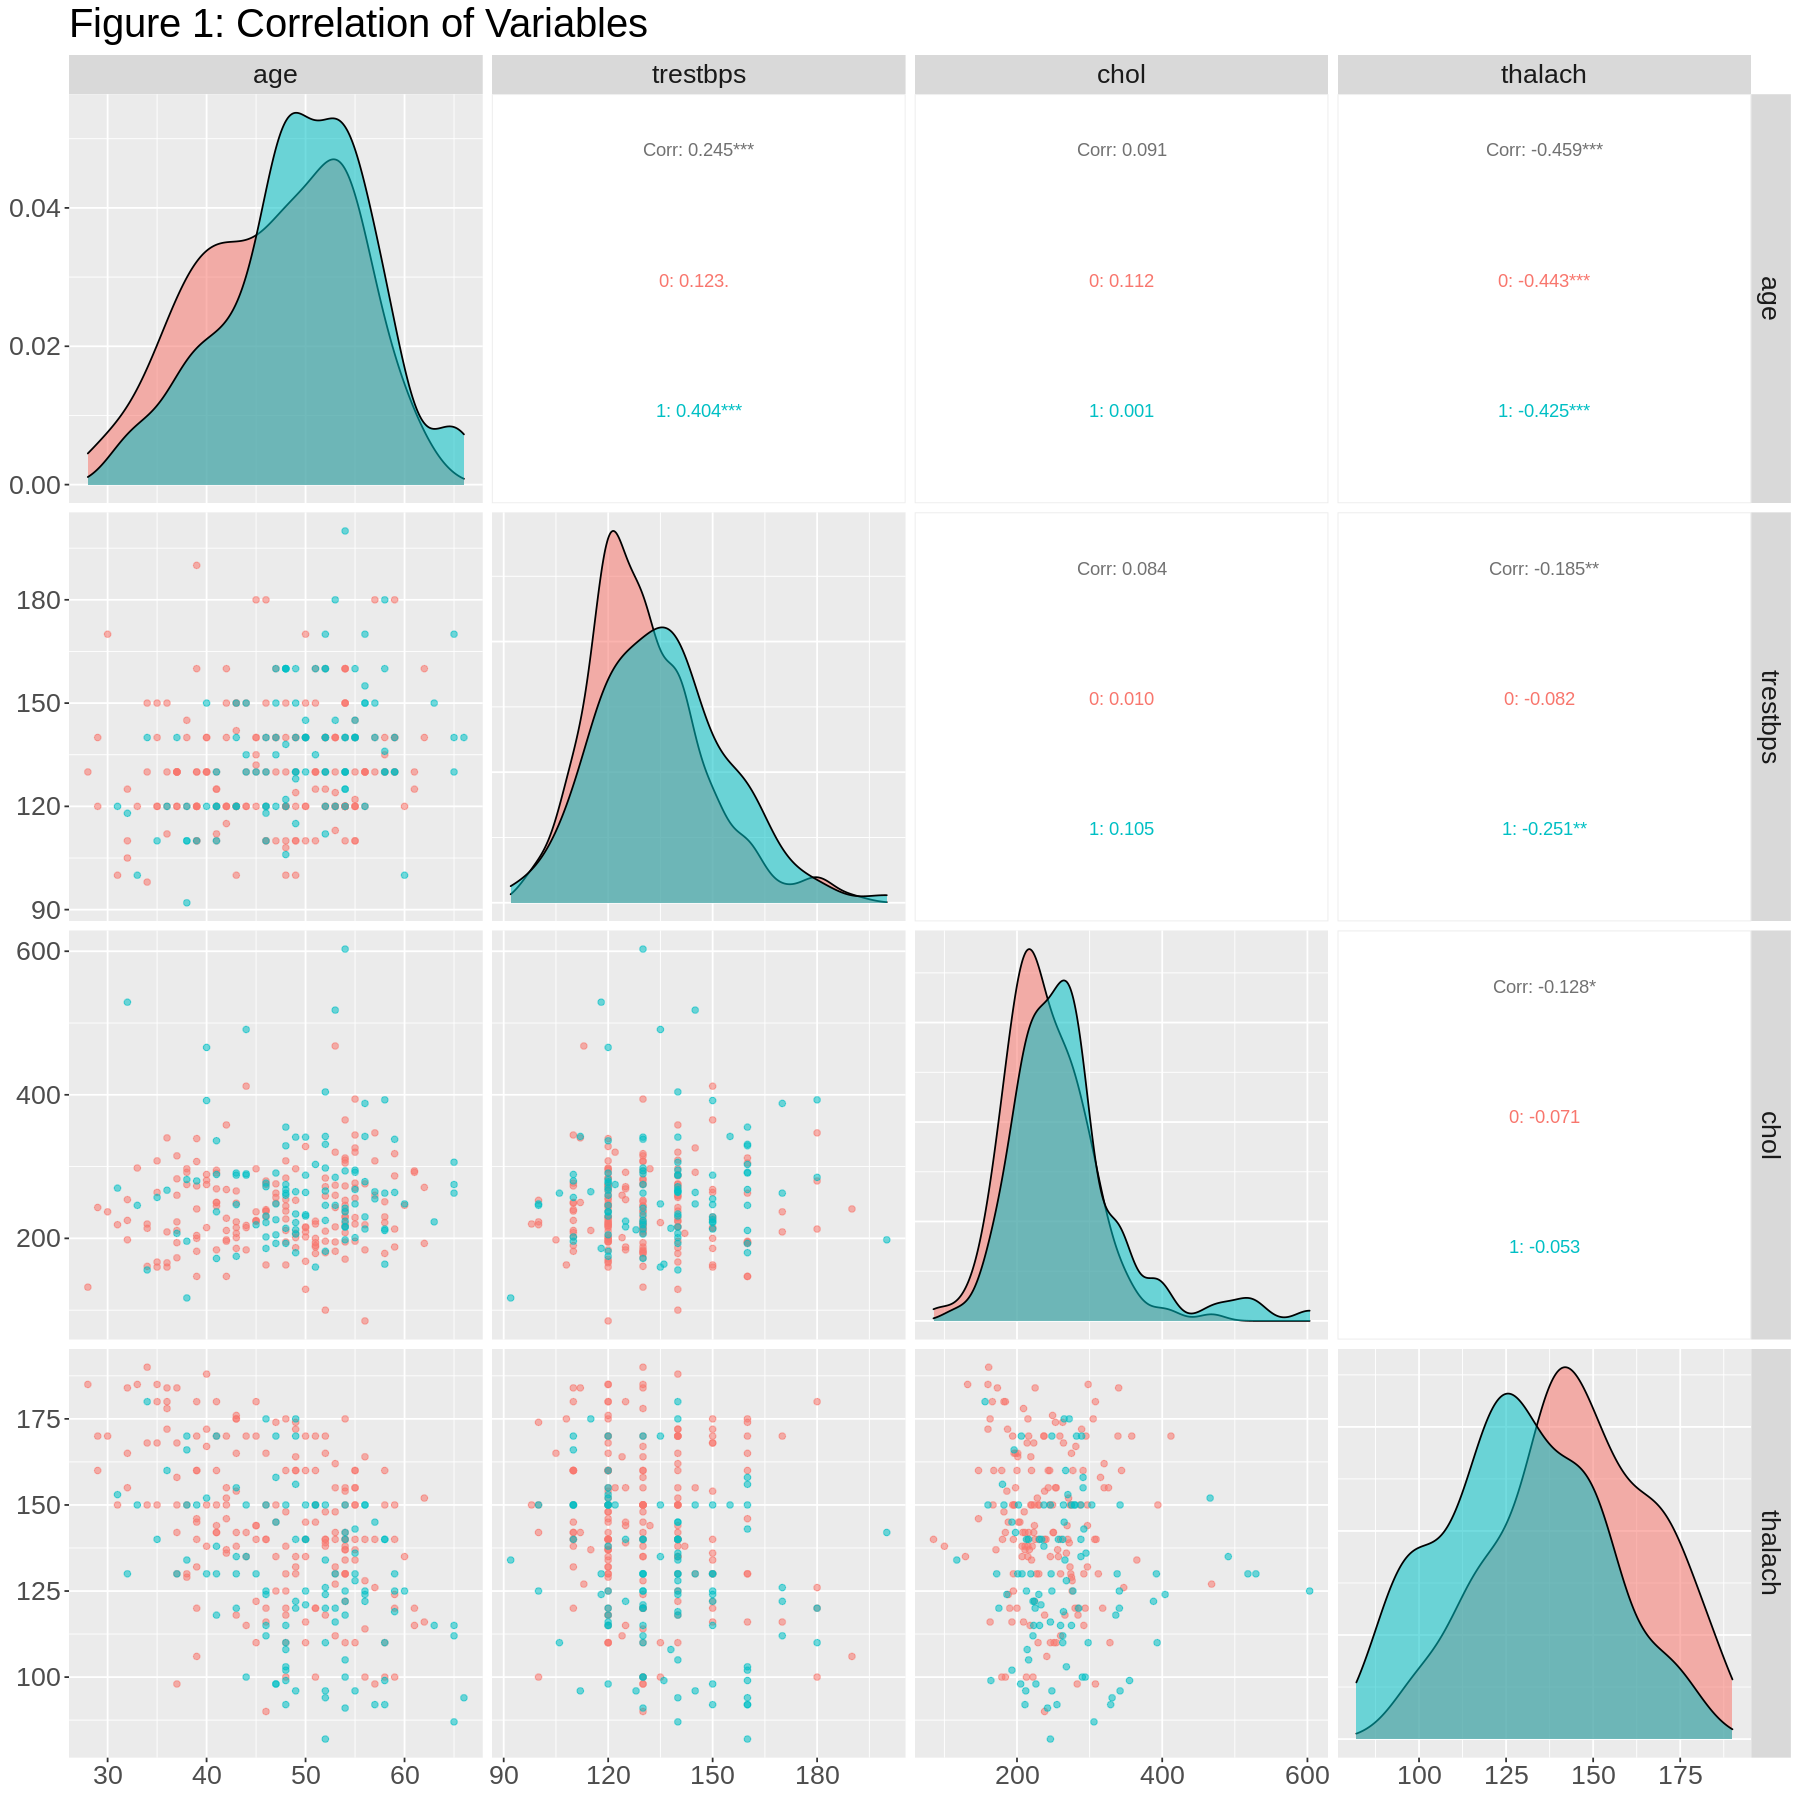

In [17]:
options(repr.plot.width = 15, repr.plot.height = 15)
pairs <- data |>
    select(age, trestbps, chol, thalach, oldpeak, diagnosis) |>
    filter(trestbps != '?' | chol != '?' | thalach != '?') |>
    mutate(trestbps = as.numeric(trestbps), chol = as.numeric(chol), thalach = as.numeric(thalach), diagnosis = as.factor(diagnosis)) |>
    ggpairs(columns = 1:4, aes(color = diagnosis, alpha = 0.2), title = "Figure 1: Correlation of Variables") +
    theme(text = element_text(size = 20))

pairs

 - The cholestrol level ("chol") and resting blood pressure ("trestbps") variables have the lowest correlation. This means that they are very different, and thus, can be useful for our prediction. Additionally, they show a strong relationship with our response variable ("diagnosis"). The graph generated for resting blood pressure shows two distinctive shapes pertaining to the presence or absense of heart disease. The graph generated for cholestrol level also shows two distinctive shapes for the presence or absence of heart disease. This analysis aided us in choosing cholestrol level and resting blood pressure as our two predictors.
 
- It is noteworthy to mention that the relationship between cholestrol level and age show a very similar pattern to that of our chosen predictors, meaning that they also have a very low correlation. However, background research shows that resting blood pressure is a more reliable risk factor for heart disease than age (refer to methods section for more information). Thus, we chose "trestbps" over "age" as our second predictor. 

<h4>3. Cleaning, wrangling, and tidying the data:</h4>

In [5]:
tidy_data <- data |>
    select(trestbps, chol, diagnosis)

head(tidy_data)

trestbps,chol,diagnosis
<chr>,<chr>,<dbl>
130,132,0
120,243,0
140,?,0
170,237,0
100,219,0
105,198,0


- We selected our two predictor variables ("trestbps" and "chol") and our explanatory variable ("num")

<h4>4. Splitting into training and testing data:</h4>

In [6]:
set.seed(3456)
data_split <- initial_split(tidy_data, prop = 3/4, strata = diagnosis)
data_train <- training(data_split)
data_test <- testing(data_split)

head(data_train)
head(data_test)

trestbps,chol,diagnosis
<chr>,<chr>,<dbl>
120,243,0
105,198,0
125,254,0
120,298,0
130,161,0
98,220,0


trestbps,chol,diagnosis
<chr>,<chr>,<dbl>
130,132,0
140,?,0
170,237,0
100,219,0
110,225,0
150,214,0


<h4>5. Summarization of the training data:</h4>

In [7]:
missing_rows <- data_train |>
    filter(trestbps == '?' | chol == '?') |>
    count()

avg_chol <- data_train |>
    select(chol) |>
    filter(chol != '?') |>
    mutate(chol = as.numeric(chol)) |>
    colMeans()

avg_trestbps <- data_train |>
    select(trestbps) |>
    filter(trestbps != '?') |>
    mutate(trestbps = as.numeric(trestbps)) |>
    colMeans()

summary_table <- data.frame(n = missing_rows, predictors_used = 2, mean_chol = avg_chol, mean_trestbps = avg_trestbps) |>
    as_tibble() |>
    mutate(incomplete_rows = n) |>
    select(!n)

summary_table

predictors_used,mean_chol,mean_trestbps,incomplete_rows
<dbl>,<dbl>,<dbl>,<int>
2,254.4902,132.589,17


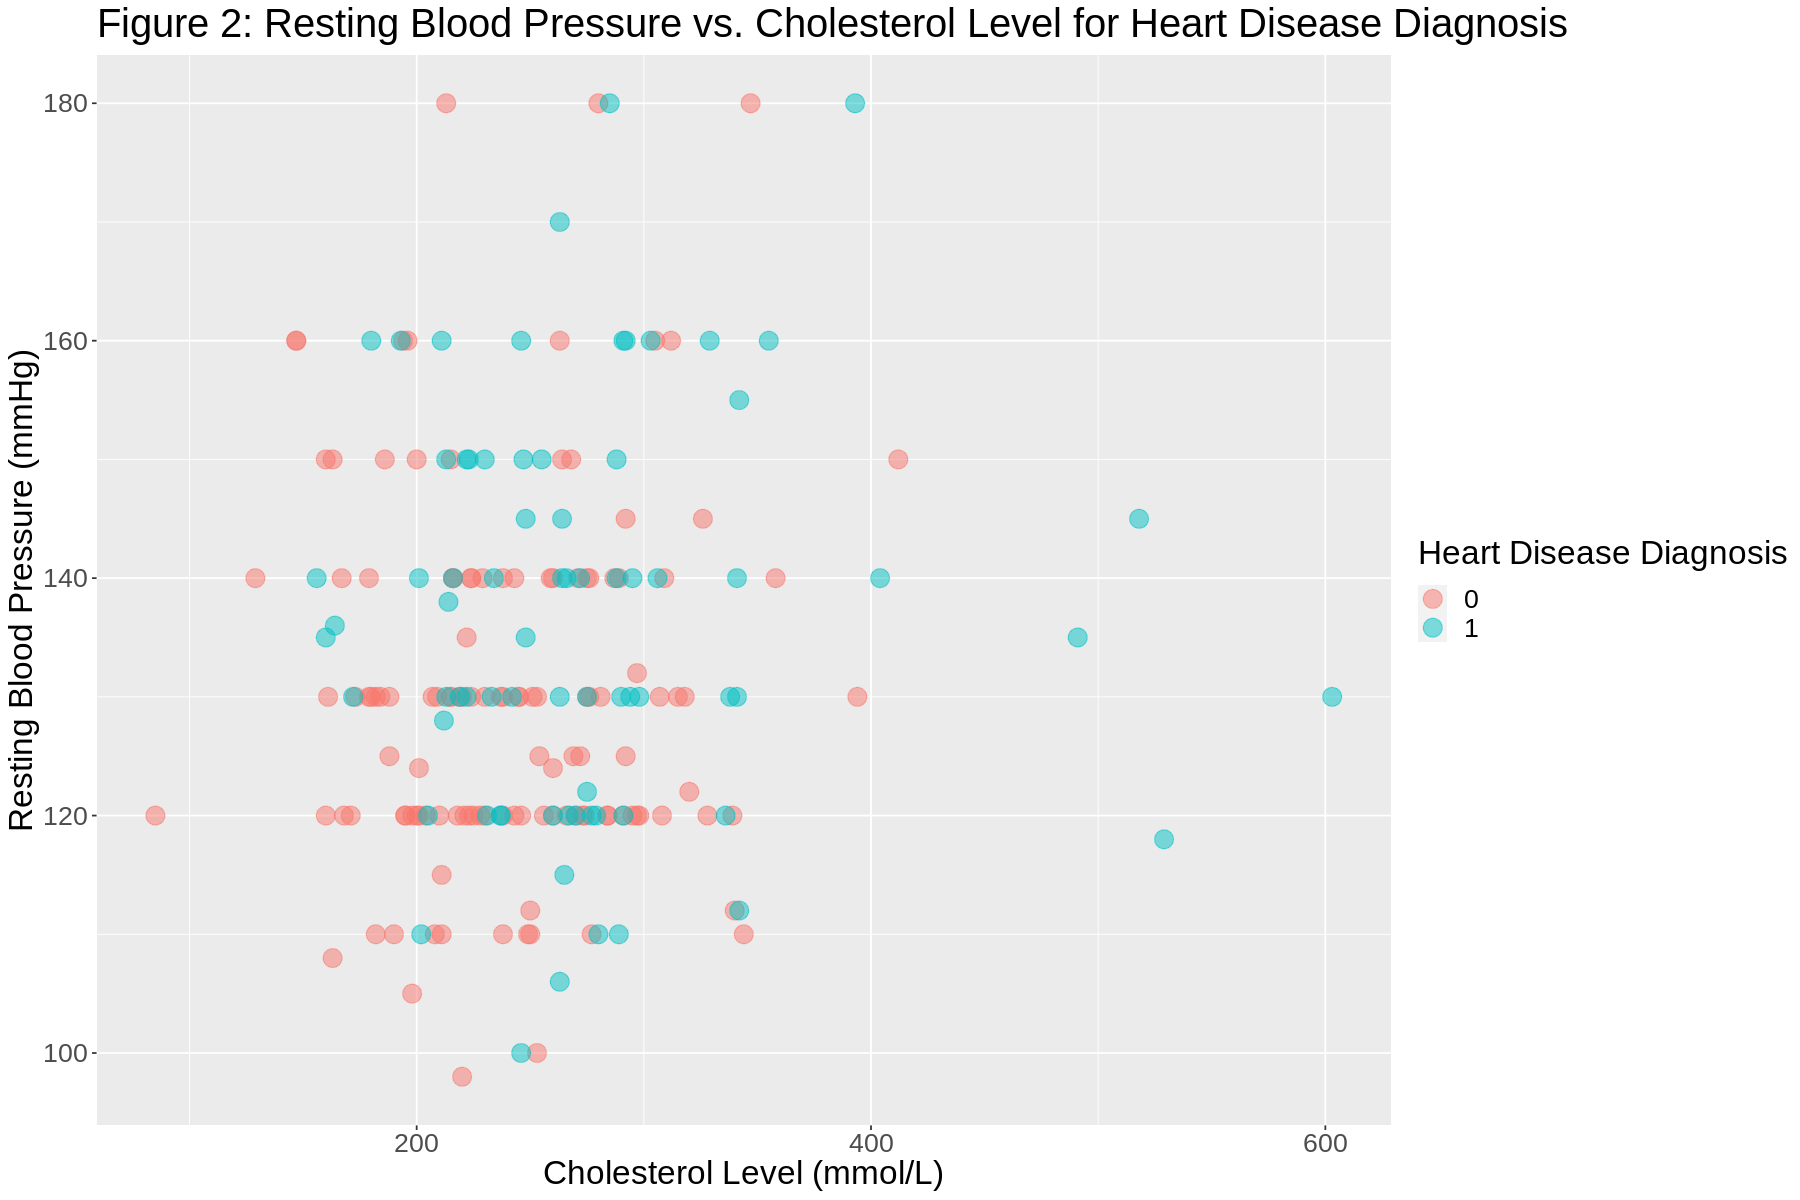

In [16]:
data_train <- data_train |>
    filter(chol != '?' & trestbps != '?') |>
    mutate(chol = as.numeric(chol), trestbps = as.numeric(trestbps), diagnosis = as.factor(diagnosis))

options(repr.plot.width = 15, repr.plot.height = 10)
training_data_plot <- data_train |> 
    ggplot(aes(x = chol, y = trestbps)) +
    geom_point(aes(color = diagnosis), size = 5, alpha = 0.5) +
    labs(x = "Cholesterol Level (mmol/L)", y = "Resting Blood Pressure (mmHg)", color = "Heart Disease Diagnosis") +
    ggtitle("Figure 2: Resting Blood Pressure vs. Cholesterol Level for Heart Disease Diagnosis") +
    theme(text = element_text(size = 20))

training_data_plot

<h2>Data Analysis</h2>

<h4>6. Making a recipe and building a model:</h4>

In [18]:
set.seed(3456)
heart_vfold <- vfold_cv(data_train, v = 5, strata = diagnosis)
heart_recipe <- recipe(diagnosis ~ chol + trestbps, data = data_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())
# heart_recipe

heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
# heart_tune

heart_metrics <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = tibble(neighbors = 1:15)) |>
    collect_metrics()

head(heart_metrics)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5665854,5,0.01589862,Preprocessor1_Model01
1,roc_auc,binary,0.5379487,5,0.01653180,Preprocessor1_Model01
2,accuracy,binary,0.5665854,5,0.01589862,Preprocessor1_Model02
2,roc_auc,binary,0.4962769,5,0.01860041,Preprocessor1_Model02
3,accuracy,binary,0.5268293,5,0.01422314,Preprocessor1_Model03
3,roc_auc,binary,0.4948615,5,0.01971515,Preprocessor1_Model03


<h4>7. Choosing the most accurate K neighbors value:</h4>

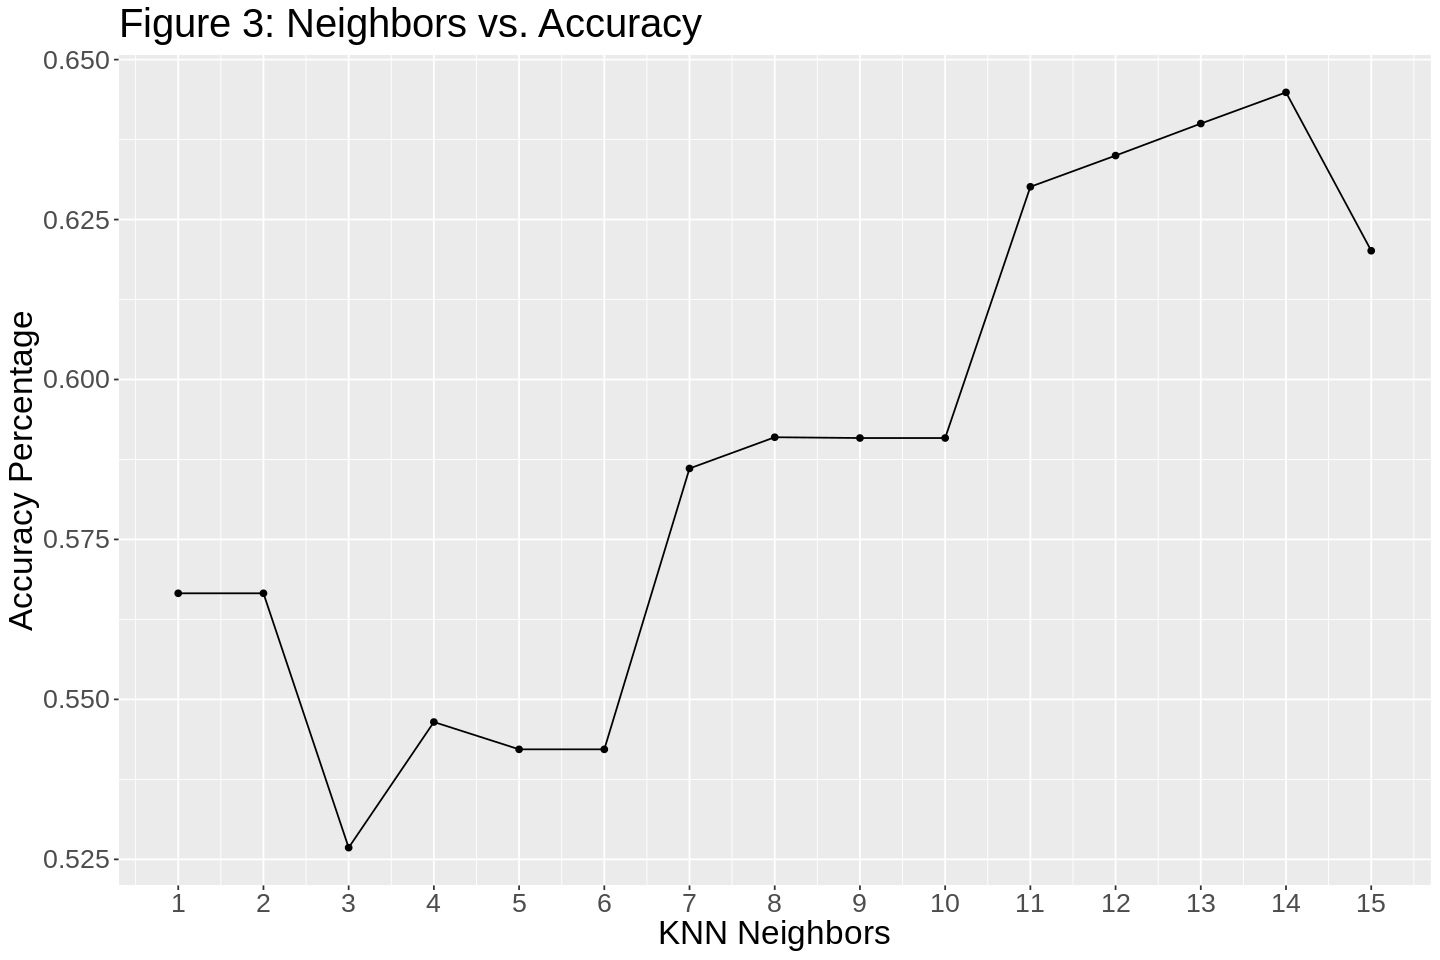

In [20]:
heart_results <- heart_metrics |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)
# heart_results

options(repr.plot.width = 12, repr.plot.height = 8)
metric_plot <- heart_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks = c(1:15)) +
    ggtitle("Figure 3: Neighbors vs. Accuracy") +
    labs(x = "KNN Neighbors", y = "Accuracy Percentage")+
    theme(text=element_text(size=20))

metric_plot

- From the plot above, we see that our model works best with 14 neighbors. Therefore, we will be choosing k=14 for our final model

In [10]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_fit <- workflow() |>
      add_recipe(heart_recipe) |>
      add_model(knn_spec) |>
      fit(data = data_train)

<h4>8. Testing and determining the overall accuracy of our model:</h4>

In [11]:
data_test <- data_test |>
    filter(chol != '?' & trestbps != '?') |>
    mutate(chol = as.numeric(chol), trestbps = as.numeric(trestbps), diagnosis = as.factor(diagnosis))

knn_test_predictions <- predict(knn_fit, data_test) |>
      bind_cols(data_test)
# head(knn_test_predictions)

heart_prediction_accuracy <- knn_test_predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")

heart_prediction_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5820896


- We can see that the overall estimation accuracy is around 58.2%, which is a bit low...

In [12]:
heart_conf_mat <- conf_mat(knn_test_predictions, truth = diagnosis, estimate = .pred_class)
heart_conf_mat

          Truth
Prediction  0  1
         0 34 21
         1  7  5

- The confusion matrix above gives us a another way to assess the estimation accuracy
- Our model was able to label 39 out of 67 observations correctly, while 28 out of 67 observations were incorrectly labeled


<h1>Discussion</h1>

<h1>References</h1>